# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm

# Creation of Combined Dataset (project_utils)

In [2]:
# OSR Dataset creation
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10


# Evaluation (project_utils)

In [3]:
def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            data = data.view(-1, 28*28)

            # Model outputs
            outputs = model(data)

            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total


# Our Model

Files already downloaded and verified


<ipython-input-5-953331b20e72>:1001: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
<ipython-in


=== Evaluation - CIFAR10/Fashion-MNIST ===
Baseline MNIST Accuracy: 99.50%


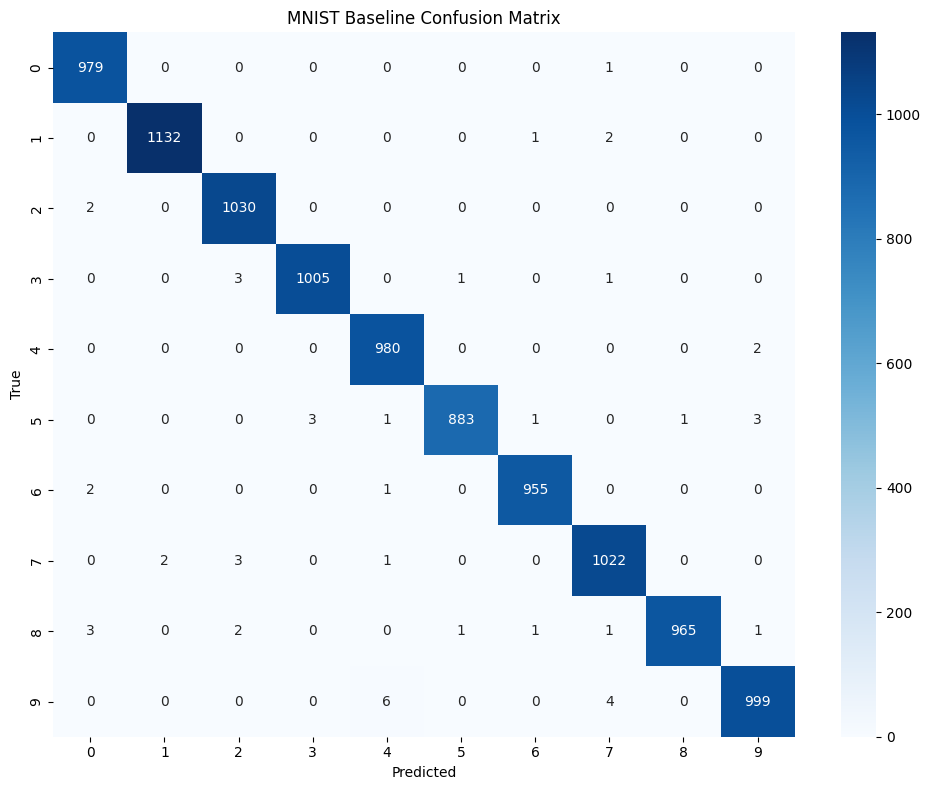

Results for CIFAR10 as OOD:
Feature dimensionality: 106


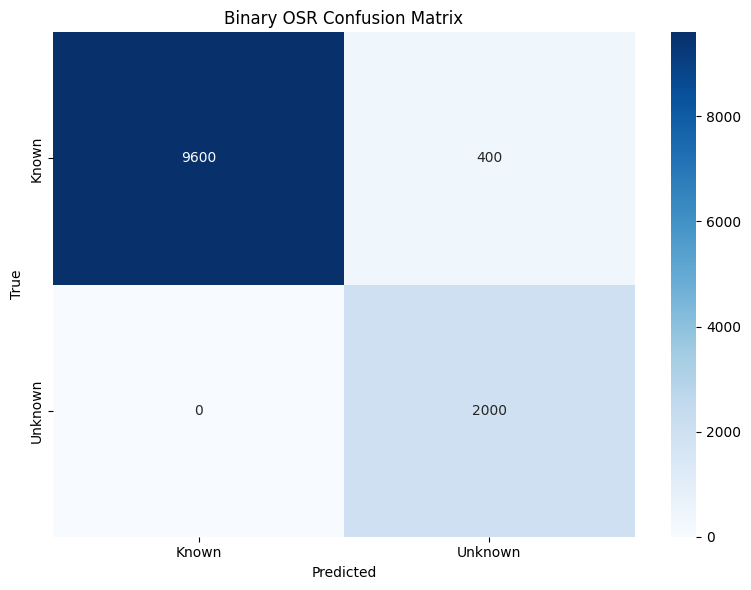

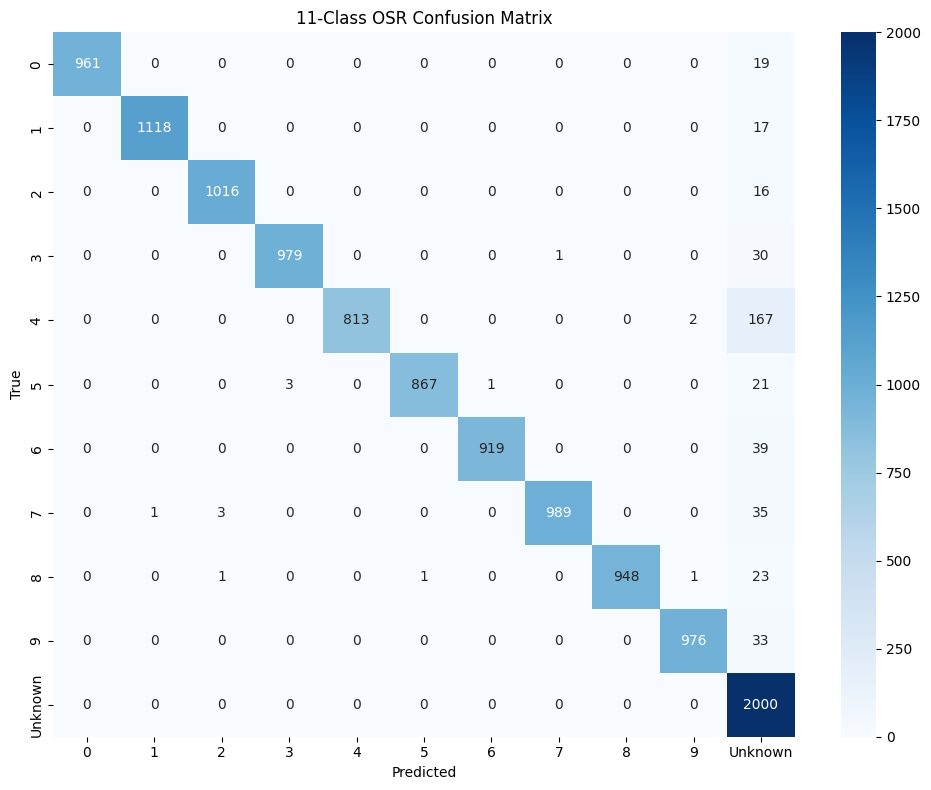

MNIST Accuracy: 95.86%
CIFAR10 OOD Accuracy: 100.00%
Total Accuracy: 96.55%


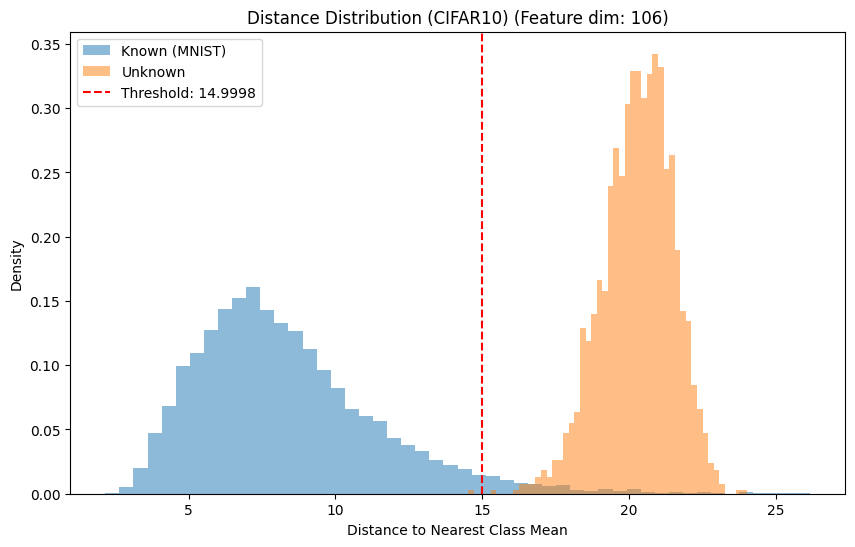

Results for FashionMNIST as OOD:
Feature dimensionality: 106


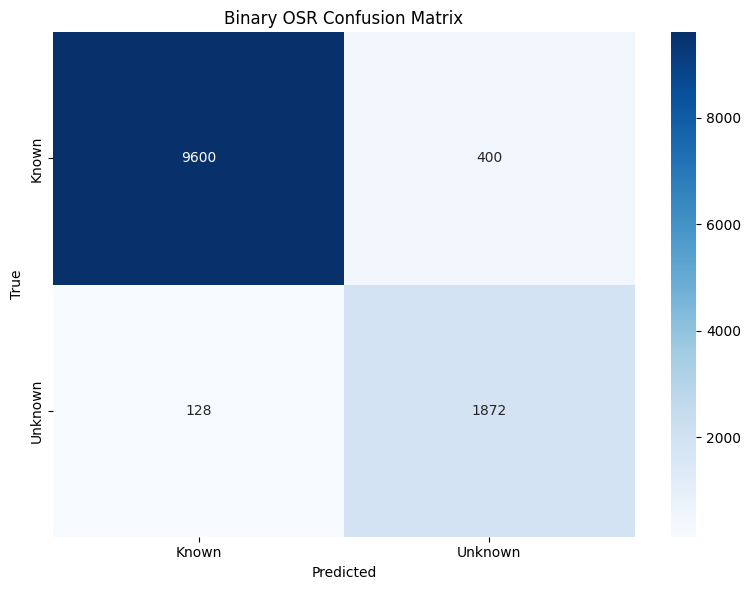

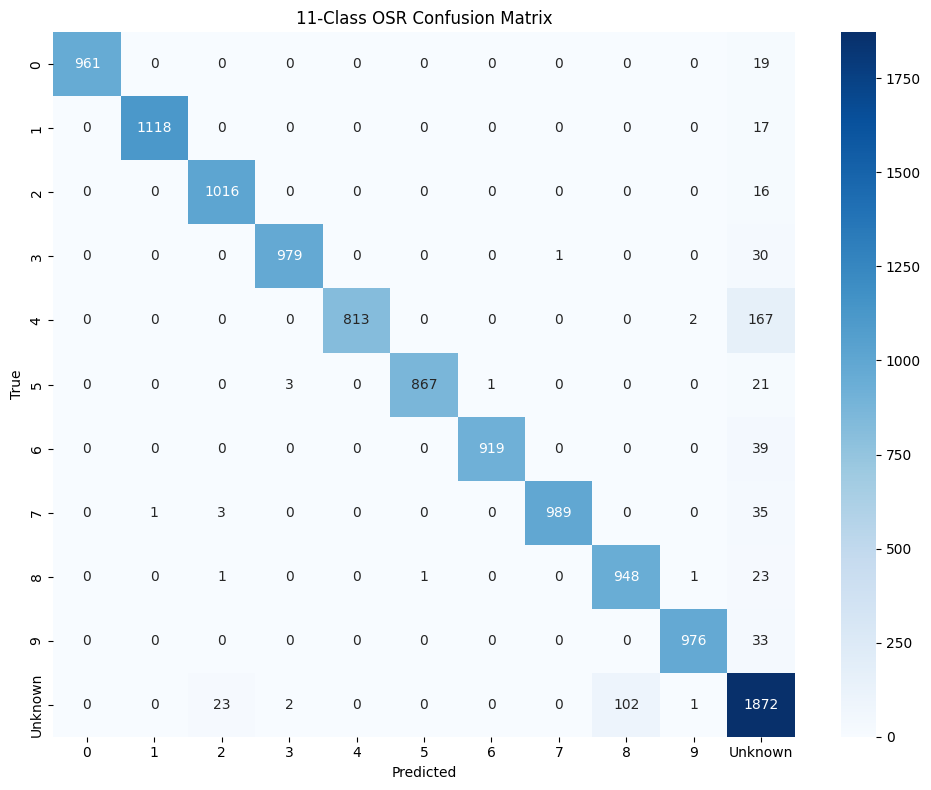

MNIST Accuracy: 95.86%
FashionMNIST OOD Accuracy: 93.60%
Total Accuracy: 95.48%


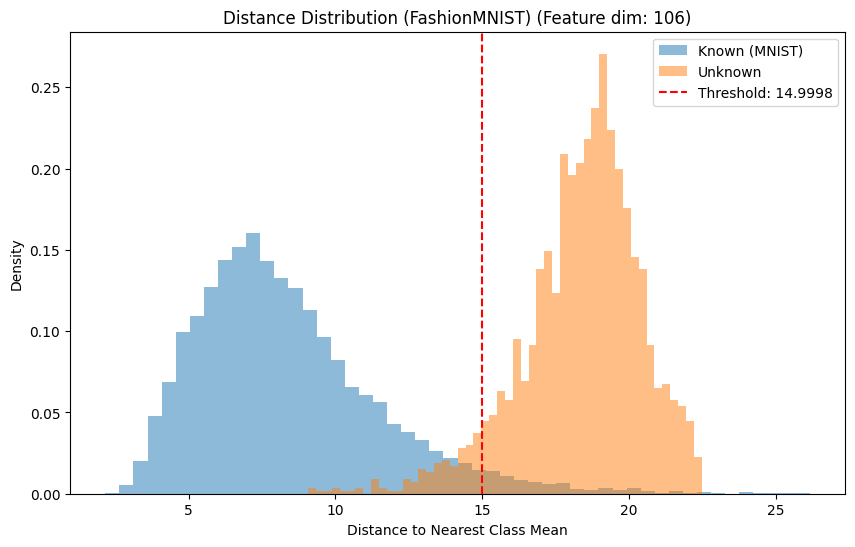


Summary of results:
Baseline MNIST Accuracy: 99.50%
CIFAR10 Binary Accuracy: 96.67%
CIFAR10 11-Class Accuracy: 96.55%
FashionMNIST Binary Accuracy: 95.60%
FashionMNIST 11-Class Accuracy: 95.48%


In [5]:
################### eval_mode flag #######################
# set to True for evaluation only, False for training
eval_mode = True

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# MNIST specific parameters
img_size = 28
input_channels = 1
num_classes = 10  # MNIST classes 0-9
unknown_class = 10  # Label for unknown samples

#######################################
# Model Implementation
#######################################

class BottleneckLayer(nn.Module):
    """
    Bottleneck layer for lateral connections in DHRNet.
    Takes features xl, compresses to zl, and then can reconstruct back.
    """
    def __init__(self, in_channels, bottleneck_dim=32):
        super(BottleneckLayer, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, bottleneck_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(bottleneck_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(bottleneck_dim, in_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        # Compress
        z = self.encoder(x)
        # Decompress
        x_proj = self.decoder(z)
        return z, x_proj

class CombinerBlock(nn.Module):
    """
    Combines decompressed lateral information with top-down information.
    """
    def __init__(self, channels):
        super(CombinerBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x_top_down, x_lateral):
        # Element-wise sum
        combined = x_top_down + x_lateral
        return self.conv(combined)

class DHRNet(nn.Module):
    """
    Deep Hierarchical Reconstruction Network with dropout for improved generalization.
    """
    def __init__(self, num_classes=10, bottleneck_dim=32, dropout_rate=0.3):
        super(DHRNet, self).__init__()
        self.num_classes = num_classes
        self.bottleneck_dim = bottleneck_dim
        self.dropout_rate = dropout_rate

        # Define the encoder pathway components
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Add dropout layers
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout_fc = nn.Dropout(dropout_rate + 0.1)

        # Fully connected layers
        self.fc1 = nn.Linear(7*7*64, 500)
        self.fc2 = nn.Linear(500, num_classes)

        # Three strategically placed bottlenecks
        self.bottleneck2 = BottleneckLayer(64, bottleneck_dim)
        self.bottleneck4 = BottleneckLayer(64, bottleneck_dim)
        self.bottleneck5 = BottleneckLayer(64, bottleneck_dim)

        # Decoder pathway
        self.combiner5 = CombinerBlock(64)
        self.combiner4 = CombinerBlock(64)
        self.combiner2 = CombinerBlock(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')

        self.deconv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.deconv1 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()

    def encode(self, x):
        """Forward pass through the encoder pathway with dropout."""
        # Handle flattened inputs
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)

        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        if self.training:
            x2 = self.dropout1(x2)
        x2_pool = self.pool1(x2)

        x3 = self.relu(self.conv3(x2_pool))
        x4 = self.relu(self.conv4(x3))
        if self.training:
            x4 = self.dropout2(x4)
        x4_pool = self.pool2(x4)

        x5 = self.relu(self.conv5(x4_pool))
        if self.training:
            x5 = self.dropout3(x5)

        # Store intermediate activations for bottlenecks
        self.activations = {
            'x1': x1,
            'x2': x2,
            'x2_pool': x2_pool,
            'x3': x3,
            'x4': x4,
            'x4_pool': x4_pool,
            'x5': x5
        }

        # Flatten and FC layers with dropout
        x_flat = x5.view(x5.size(0), -1)
        fc1 = self.relu(self.fc1(x_flat))
        if self.training:
            fc1 = self.dropout_fc(fc1)
        logits = self.fc2(fc1)

        return logits

    def get_bottlenecks(self):
        """Extract and process bottleneck representations."""
        # Only extract the 3 bottlenecks we've kept
        z2, x2_proj = self.bottleneck2(self.activations['x2_pool'])
        z4, x4_proj = self.bottleneck4(self.activations['x4_pool'])
        z5, x5_proj = self.bottleneck5(self.activations['x5'])

        # Return only the necessary z values and projections
        return z2, z4, z5, x2_proj, x4_proj, x5_proj

    def decode(self, x5, x2_proj, x4_proj, x5_proj):
        """Decoder pathway for reconstruction."""
        # Start reconstruction from the deepest layer
        x_tilde = x5

        # Hierarchical reconstruction with fewer lateral connections
        x_tilde = self.combiner5(x_tilde, x5_proj)
        x_tilde = self.relu(self.deconv5(x_tilde))

        # Resize if needed to match spatial dimensions
        if x_tilde.size(2) != x4_proj.size(2) or x_tilde.size(3) != x4_proj.size(3):
            x_tilde = F.interpolate(x_tilde, size=(x4_proj.size(2), x4_proj.size(3)), mode='bilinear', align_corners=False)

        x_tilde = self.combiner4(x_tilde, x4_proj)
        x_tilde = self.upsample2(x_tilde)
        x_tilde = self.relu(self.deconv4(x_tilde))

        # Resize if needed to match spatial dimensions
        if x_tilde.size(2) != x2_proj.size(2) or x_tilde.size(3) != x2_proj.size(3):
            x_tilde = F.interpolate(x_tilde, size=(x2_proj.size(2), x2_proj.size(3)), mode='bilinear', align_corners=False)

        x_tilde = self.combiner2(x_tilde, x2_proj)
        x_tilde = self.upsample1(x_tilde)
        x_tilde = self.relu(self.deconv2(x_tilde))

        x_tilde = torch.sigmoid(self.deconv1(x_tilde))

        return x_tilde

    def forward(self, x):
        """Full forward pass for both classification and reconstruction."""
        # Handle flattened inputs
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)

        # Encode for classification
        logits = self.encode(x)

        # Get bottleneck representations (fewer now)
        z2, z4, z5, x2_proj, x4_proj, x5_proj = self.get_bottlenecks()

        # Decode for reconstruction
        x_tilde = self.decode(self.activations['x5'], x2_proj, x4_proj, x5_proj)

        return logits, x_tilde, z2, z4, z5

    def extract_features(self, x):
        """Extract all features required for open-set recognition."""
        # Handle flattened inputs
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)

        logits = self.encode(x)
        z2, z4, z5, _, _, _ = self.get_bottlenecks()

        # Using global max pooling for each bottleneck
        z2_flat = F.max_pool2d(z2, kernel_size=z2.size()[2:]).view(z2.size(0), -1)
        z4_flat = F.max_pool2d(z4, kernel_size=z4.size()[2:]).view(z4.size(0), -1)
        z5_flat = F.max_pool2d(z5, kernel_size=z5.size()[2:]).view(z5.size(0), -1)

        # Concatenate bottleneck representations
        z_combined = torch.cat([z2_flat, z4_flat, z5_flat], dim=1)

        return logits, z_combined



class WeibullDistribution:
    """Weibull distribution fitting for open-set recognition."""

    def __init__(self):
        self.shape = None
        self.scale = None

    def fit(self, distances, tail_size=20):
        """Fit Weibull distribution to the tail of distance values."""
        if len(distances) == 0:
            self.shape = 1.0
            self.scale = 1.0
            return self

        # Sort distances and use only the tail values
        distances = np.sort(distances)
        if len(distances) > tail_size:
            distances = distances[-tail_size:]

        # Define negative log-likelihood function
        def neg_log_likelihood(params):
            shape, scale = params
            if shape <= 0 or scale <= 0:
                return float('inf')

            n = len(distances)
            log_likelihood = n * np.log(shape / scale) + \
                            (shape - 1) * np.sum(np.log(np.maximum(distances, 1e-8))) - \
                            np.sum((distances / scale) ** shape)
            return -log_likelihood

        # Initial parameters
        shape_init = 0.8
        scale_init = np.mean(distances)
        initial_params = [shape_init, scale_init]

        # Optimize parameters
        bounds = [(0.1, 10), (min(distances), max(distances) * 2)]
        try:
            result = optimize.minimize(
                neg_log_likelihood,
                initial_params,
                bounds=bounds,
                method='L-BFGS-B'
            )
            self.shape, self.scale = result.x
        except:
            # Fallback to simpler estimation
            mean = np.mean(distances)
            var = np.var(distances)
            if var > 0:
                cv = np.sqrt(var) / mean
                self.shape = 0.9 / cv
                self.scale = mean / np.exp(np.log(2.0)**(1.0/self.shape))
            else:
                self.shape = 0.8
                self.scale = mean

        return self



class CROSRModel(nn.Module):
    """
    Classification-Reconstruction learning for Open-Set Recognition (CROSR) model.
    This is the OSR model class that uses DHRNet and adds unknown detection capability.
    """
    def __init__(self, num_classes=10, bottleneck_dim=32, threshold=None):
        super(CROSRModel, self).__init__()
        self.num_classes = num_classes
        self.unknown_class = num_classes  # Unknown class is the next index after known classes
        self.threshold = threshold  # Threshold for unknown detection

        self.dhr_net = DHRNet(num_classes=num_classes, bottleneck_dim=bottleneck_dim)

        # Calculate the total dimension of z_combined
        # 3 bottlenecks
        self.z_dim = bottleneck_dim * 3

        # Class means will be computed after training
        self.class_means = None
        self.weibull_params = None
        self.fitted = False

    def fit_weibull(self, distance_per_class, tail_size=20):
        """
        Fit Weibull distribution to distances from class means.
        """
        self.weibull_params = []

        for distances in distance_per_class:
            if len(distances) == 0:
                # Default values for empty classes
                self.weibull_params.append((1.0, 1.0))
                continue

            weibull = WeibullDistribution()
            weibull.fit(distances, tail_size=tail_size)
            self.weibull_params.append((weibull.shape, weibull.scale))

        return self

    def compute_openmax_probabilities(self, logits, distances):
      alpha = 6
      weibull_multiplier = 1.5
      min_rejection_threshold = 0.3
      min_alpha_value = 0.2

      batch_size = logits.size(0)
      calibrated = torch.zeros(batch_size, self.num_classes + 1, device=logits.device)

      softmax_probs = F.softmax(logits, dim=1)

      for i in range(batch_size):
          # Sort classes by activation in descending order
          sorted_idx = torch.argsort(logits[i], descending=True)

          # Initialize calibration weights
          alphas = torch.zeros(self.num_classes, device=logits.device)

          # Calculate calibration weights based on rank and Weibull score
          for rank, idx in enumerate(sorted_idx):
              idx = idx.item()
              if rank < alpha:
                  distance = distances[i, idx].item()

                  if self.weibull_params is not None:
                      # Compute Weibull CDF using fitted parameters
                      shape, scale = self.weibull_params[idx]

                      # Compute rank calibration
                      rank_prob = max(0, (alpha - rank) / alpha)

                      # Weibull CDF for probability of not belonging
                      try:
                          weibull_score = 1.0 - np.exp(-((distance / scale) ** shape))
                          # Apply multiplier to increase influence of Weibull score
                          weibull_score = min(1.0, weibull_score * weibull_multiplier)

                          # Apply minimum rejection threshold
                          if weibull_score > min_rejection_threshold:
                              alphas[idx] = max(rank_prob * weibull_score, min_alpha_value)
                          else:
                              alphas[idx] = rank_prob * weibull_score
                      except:
                          weibull_score = 1.0 if distance > scale * 5 else 0.0
                          alphas[idx] = rank_prob * weibull_score
                  else:
                      # If using statistical threshold
                      if self.threshold is not None and distance > self.threshold:
                          alphas[idx] = 1.0

          # Apply calibration to each class probability
          for j in range(self.num_classes):
              calibrated[i, j] = softmax_probs[i, j] * (1.0 - alphas[j])

          # Compute unknown probability
          calibrated[i, self.unknown_class] = torch.sum(softmax_probs[i] * alphas)

          # Re-normalize the known class probabilities
          if calibrated[i, self.unknown_class] < 1.0:
              known_sum = torch.sum(calibrated[i, :self.num_classes])
              if known_sum > 0:
                  calibrated[i, :self.num_classes] = calibrated[i, :self.num_classes] * (1.0 - calibrated[i, self.unknown_class]) / known_sum

      return calibrated

    def compute_class_means(self, dataloader, device):
        """
        Compute class means in the joint space of classification output (y)
        and latent representation (z) for each known class.
        """
        self.dhr_net.eval()

        class_features = [[] for _ in range(self.num_classes)]

        with torch.no_grad():
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                logits, z_combined = self.dhr_net.extract_features(data)
                combined = torch.cat([logits, z_combined], dim=1)

                # Add features to corresponding class lists
                for i in range(self.num_classes):
                    idx = (target == i)
                    if torch.any(idx):
                        class_features[i].append(combined[idx])

        # Compute mean for each class
        self.class_means = []
        for i in range(self.num_classes):
            if class_features[i]:
                features = torch.cat(class_features[i], dim=0)
                mean = torch.mean(features, dim=0)
                self.class_means.append(mean)
            else:
                # If no samples for this class, use zeros
                feature_dim = combined.size(1)
                self.class_means.append(torch.zeros(feature_dim, device=device))

        self.class_means = torch.stack(self.class_means)

    def compute_distances(self, logits, z_combined):
        """
        Compute distances to class centroids in the joint space.
        """
        combined = torch.cat([logits, z_combined], dim=1)
        batch_size = combined.size(0)
        distances = torch.zeros(batch_size, self.num_classes, device=combined.device)

        # Compute distances to each class mean
        for i in range(self.num_classes):
            diff = combined - self.class_means[i].unsqueeze(0)
            distances[:, i] = torch.norm(diff, dim=1)

        return distances

    def fit_for_osr(self, train_loader, device, statistical_threshold=False, sigma_multiplier=2.0, tail_size=20):
        """
        Prepare the model for OSR by computing class means and fitting Weibull distribution.
        """
        self.compute_class_means(train_loader, device)

        # Collect distances for Weibull fitting
        distances_per_class = [[] for _ in range(self.num_classes)]
        all_min_distances = []

        self.dhr_net.eval()
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                logits, z_combined = self.dhr_net.extract_features(data)
                distances = self.compute_distances(logits, z_combined)

                # Record minimum distances for statistical threshold
                min_distances, _ = torch.min(distances, dim=1)
                all_min_distances.extend(min_distances.cpu().numpy())

                # Add distances to corresponding class lists
                for i in range(self.num_classes):
                    idx = (target == i)
                    if torch.any(idx):
                        class_distances = distances[idx, i].cpu().numpy()
                        distances_per_class[i].extend(class_distances.tolist())

        if statistical_threshold:
            # Set threshold using mean and standard deviation of known class distances
            mean_distance = np.mean(all_min_distances)
            std_distance = np.std(all_min_distances)
            adjusted_multiplier = sigma_multiplier * (1 + 0.1 * np.log2(self.z_dim / 64))
            self.threshold = mean_distance + adjusted_multiplier * std_distance
            print(f"Setting statistical threshold: {self.threshold:.4f} (adjusted for {self.z_dim}-dim space)")
            self.weibull_params = None
        else:
            # Fit Weibull distribution
            print(f"Fitting enhanced Weibull distribution with tail size {tail_size}...")
            self.threshold = None
            self.fit_weibull(distances_per_class, tail_size=tail_size)

        self.fitted = True
        return self

    def forward(self, x):
        """
        Forward pass with unknown detection.
        """
        # Handle flattened inputs
        if x.dim() == 2:
            x_reshaped = x.view(-1, 1, 28, 28)
            logits, z_combined = self.dhr_net.extract_features(x_reshaped)
        else:
            logits, z_combined = self.dhr_net.extract_features(x)

        if not self.fitted:
            # If the model is not fitted for OSR, return standard predictions
            probs = F.softmax(logits, dim=1)
            batch_size = probs.size(0)

            # Add zero probability for unknown class
            result = torch.zeros(batch_size, self.num_classes + 1, device=probs.device)
            result[:, :self.num_classes] = probs
            return result

        distances = self.compute_distances(logits, z_combined)
        calibrated = self.compute_openmax_probabilities(logits, distances)

        return calibrated

#######################################
# Data Preparation Functions
#######################################

def prepare_datasets(batch_size=256):
    """
    Prepare datasets for training and evaluation.
    """
    # Standard transforms for MNIST with normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Data augmentation transform for training
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Transform for CIFAR10/FashionMNIST to convert to grayscale and resize
    ood_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load MNIST datasets
    train_set = MNIST('./data', train=True, download=True, transform=train_transform)
    test_set = MNIST('./data', train=False, download=True, transform=transform)

    # Split training set into train and validation
    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

    # For validation, use the standard transform
    val_set = MNIST('./data', train=True, download=True, transform=transform)
    val_indices = range(train_size, len(val_set))
    val_set = torch.utils.data.Subset(val_set, val_indices)

    # Load CIFAR10 for OOD evaluation
    cifar10 = CIFAR10('./data', train=False, download=True, transform=ood_transform)

    # Load FashionMNIST for OOD evaluation
    fashion_mnist = FashionMNIST('./data', train=False, download=True, transform=ood_transform)

    # Sample subsets of OOD datasets
    ood_size = 2000
    cifar_indices = torch.randperm(len(cifar10))[:ood_size]
    fashion_indices = torch.randperm(len(fashion_mnist))[:ood_size]

    cifar_subset = torch.utils.data.Subset(cifar10, cifar_indices)
    fashion_subset = torch.utils.data.Subset(fashion_mnist, fashion_indices)

    # Create combined datasets for OSR evaluation
    cifar_combined = CombinedDataset(test_set, cifar_subset)
    fashion_combined = CombinedDataset(test_set, fashion_subset)

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    cifar_loader = DataLoader(cifar_subset, batch_size=batch_size)
    fashion_loader = DataLoader(fashion_subset, batch_size=batch_size)
    cifar_combined_loader = DataLoader(cifar_combined, batch_size=batch_size)
    fashion_combined_loader = DataLoader(fashion_combined, batch_size=batch_size)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'cifar_loader': cifar_loader,
        'fashion_loader': fashion_loader,
        'cifar_combined_loader': cifar_combined_loader,
        'fashion_combined_loader': fashion_combined_loader
    }


#######################################
# Training Functions
#######################################

def train_dhrnet(model, train_loader, val_loader, device, epochs=20, lr=0.001, weight_recon=1.0):
    """
    Train the DHRNet model with classification and reconstruction losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    cls_criterion = nn.CrossEntropyLoss()
    recon_criterion = nn.MSELoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        cls_losses = 0.0
        recon_losses = 0.0

        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)

            # Forward pass
            logits, x_tilde, z2, z4, z5 = model(data)

            # Compute losses
            cls_loss = cls_criterion(logits, target)
            recon_loss = recon_criterion(x_tilde, data)
            loss = cls_loss + weight_recon * recon_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            cls_losses += cls_loss.item()
            recon_losses += recon_loss.item()

        # Average losses
        train_loss /= len(train_loader)
        cls_losses /= len(train_loader)
        recon_losses /= len(train_loader)
        train_losses.append(train_loss)


        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)

                # Forward pass
                logits, _, z2, z4, z5 = model(data)

                # Compute accuracy
                _, predicted = torch.max(logits, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Update learning rate
        scheduler.step(train_loss)

    return train_losses, val_accuracies

#######################################
# Evaluation Functions
#######################################

def evaluate_baseline(model, test_loader, device):
    """Evaluate the baseline model on the MNIST test set."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass - updated to handle 5 return values
            logits, _, z2, z4, z5 = model(data)

            # Compute accuracy
            _, predicted = torch.max(logits, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    accuracy = correct / total
    print(f"Baseline MNIST Accuracy: {accuracy*100:.2f}%")

    # Plot confusion matrix
    class_names = [str(i) for i in range(10)]
    plot_confusion_matrix(all_targets, all_preds, class_names, title="MNIST Baseline Confusion Matrix")

    return accuracy, all_preds, all_targets

def evaluate_osr_binary(model, test_loader, unknown_loader, device):
    """
    Evaluate OSR model for binary classification (known vs unknown).
    """
    model.eval()

    # Evaluate on known data
    correct_known = 0
    total_known = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)

            # Forward pass with OSR detection
            probs = model(data)

            # Check if samples are classified as known (not class 10)
            _, predicted = torch.max(probs, 1)
            is_known = (predicted < 10)

            total_known += data.size(0)
            correct_known += is_known.sum().item()

    # Evaluate on unknown data
    correct_unknown = 0
    total_unknown = 0
    with torch.no_grad():
        for data, _ in unknown_loader:
            data = data.to(device)

            # Forward pass with OSR detection
            probs = model(data)

            # Check if samples are classified as unknown (class 10)
            _, predicted = torch.max(probs, 1)
            is_unknown = (predicted == 10)

            total_unknown += data.size(0)
            correct_unknown += is_unknown.sum().item()

    known_acc = correct_known / total_known if total_known > 0 else 0
    unknown_acc = correct_unknown / total_unknown if total_unknown > 0 else 0
    total_acc = (correct_known + correct_unknown) / (total_known + total_unknown)

    # Print additional information about the high-dimensional space
    print(f"Feature dimensionality: {model.z_dim + model.num_classes}")

    # Create binary confusion matrix data
    cm = [
        [correct_known, total_known - correct_known],
        [total_unknown - correct_unknown, correct_unknown]
    ]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Binary OSR Confusion Matrix')
    plt.tight_layout()
    plt.savefig('binary_osr_confusion_matrix.png')
    plt.show()

    return known_acc, unknown_acc, total_acc

def evaluate_osr_multiclass(model, combined_loader, device):
    """
    Evaluate OSR model for multiclass classification (10 MNIST classes + Unknown).
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in combined_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass with OSR capability
            outputs = model(data)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate accuracy
    correct = (np.array(all_preds) == np.array(all_targets)).sum()
    total = len(all_targets)
    accuracy = correct / total

    # Plot confusion matrix with all 11 classes
    class_names = [str(i) for i in range(10)] + ["Unknown"]
    plot_confusion_matrix(all_targets, all_preds, class_names, title="11-Class OSR Confusion Matrix")

    return accuracy, all_preds, all_targets

def plot_confusion_matrix(y_true, y_pred, classes, title=None):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

def plot_training_history(train_losses, val_accuracies):
    """
    Plot training loss and validation accuracy.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def visualize_reconstructions(model, dataloader, device, num_samples=10):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]

    with torch.no_grad():
        logits, reconstructions, z2, z4, z5 = model(images)

    # Plot original images and reconstructions
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    for i in range(num_samples):
        # Original image
        img = images[i].cpu().squeeze().numpy()
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Original: {labels[i]}')
        axes[0, i].axis('off')

        # Reconstruction
        recon = reconstructions[i].cpu().squeeze().numpy()
        axes[1, i].imshow(recon, cmap='gray')
        axes[1, i].set_title('Reconstruction')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()

def plot_distance_distribution(model, known_loader, unknown_loader, device, title=None):
    """
    Plot distribution of distances for known and unknown samples.
    """
    model.eval()
    known_distances = []
    unknown_distances = []

    # Compute distances for known samples
    with torch.no_grad():
        for data, _ in known_loader:
            data = data.to(device)

            # Extract features
            logits, z_combined = model.dhr_net.extract_features(data)

            # Compute distances
            distances = model.compute_distances(logits, z_combined)

            # Get minimum distance for each sample
            min_distances, _ = torch.min(distances, dim=1)
            known_distances.extend(min_distances.cpu().numpy())

    # Compute distances for unknown samples
    with torch.no_grad():
        for data, _ in unknown_loader:
            data = data.to(device)

            # Extract features
            logits, z_combined = model.dhr_net.extract_features(data)

            # Compute distances
            distances = model.compute_distances(logits, z_combined)

            # Get minimum distance for each sample
            min_distances, _ = torch.min(distances, dim=1)
            unknown_distances.extend(min_distances.cpu().numpy())


    # Adjust bins based on higher dimensionality
    num_bins = min(50, int(np.sqrt(len(known_distances))))

    # Plot distributions
    plt.figure(figsize=(10, 6))
    plt.hist(known_distances, bins=num_bins, alpha=0.5, label='Known (MNIST)', density=True)
    plt.hist(unknown_distances, bins=num_bins, alpha=0.5, label='Unknown', density=True)

    if model.threshold is not None:
        plt.axvline(model.threshold, color='red', linestyle='--', label=f'Threshold: {model.threshold:.4f}')

    plt.legend()
    plt.xlabel('Distance to Nearest Class Mean')
    plt.ylabel('Density')
    if title:
        plt.title(f"{title} (Feature dim: {model.z_dim + model.num_classes})")
    else:
        plt.title(f"Distance Distribution (Feature dim: {model.z_dim + model.num_classes})")

    plt.savefig(f"{title.replace(' ', '_').lower() if title else 'distance_distribution'}.png")
    plt.show()

    return known_distances, unknown_distances


#######################################
# Main Code
#######################################

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data = prepare_datasets(batch_size=256)

    # Initialize models with dropout
    dropout_rate = 0.3  # Adjust based on experimentation
    baseline_model = DHRNet(num_classes=10, bottleneck_dim=32, dropout_rate=dropout_rate).to(device)
    osr_model = CROSRModel(num_classes=10, bottleneck_dim=32).to(device)
    osr_model.dhr_net = baseline_model

    baseline_path = './baseline_model.pth'
    osr_path = './osr_model.pth'

    if not eval_mode:
        # Training phase
        print("\nTraining baseline model...")
        train_losses, val_accuracies = train_dhrnet(
            baseline_model,
            data['train_loader'],
            data['val_loader'],
            device,
            epochs=17,
            lr=0.001,
            weight_recon=1.0
        )

        # Plot training history
        plot_training_history(train_losses, val_accuracies)

        # Visualize some reconstructions
        visualize_reconstructions(baseline_model, data['test_loader'], device)

        # Save baseline model
        torch.save(baseline_model.state_dict(), baseline_path)

        # Set up OSR model with the trained baseline
        osr_model.dhr_net.load_state_dict(baseline_model.state_dict())

        # Prepare OSR model for unknown detection
        osr_model.fit_for_osr(
            data['train_loader'],
            device,
            statistical_threshold=True
        )

        # Save OSR model
        torch.save({
            'model_state_dict': osr_model.dhr_net.state_dict(),
            'class_means': osr_model.class_means,
            'threshold': osr_model.threshold,
            'weibull_params': osr_model.weibull_params,
            'fitted': osr_model.fitted
        }, osr_path)


    else:
        # Evaluation phase
        # Loading baseline and OSR models
        baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))

        checkpoint = torch.load(osr_path, map_location=device)
        osr_model.dhr_net.load_state_dict(checkpoint['model_state_dict'])
        osr_model.class_means = checkpoint['class_means']
        osr_model.threshold = checkpoint['threshold']
        osr_model.weibull_params = checkpoint.get('weibull_params')
        osr_model.fitted = checkpoint['fitted']

        #######################################
        # Evaluation - CIFAR10/Fashion-MNIST
        #######################################
        print("\n=== Evaluation - CIFAR10/Fashion-MNIST ===")

        # Baseline results on MNIST test set
        baseline_acc, baseline_preds, baseline_targets = evaluate_baseline(baseline_model, data['test_loader'], device)

        # CIFAR10 as unknown
        print("Results for CIFAR10 as OOD:")
        # Binary classification (Known vs Unknown)
        cifar_known_acc, cifar_unknown_acc, cifar_binary_acc = evaluate_osr_binary(
            osr_model,
            data['test_loader'],
            data['cifar_loader'],
            device
        )

        # Multiclass classification with 11 classes
        cifar_multiclass_acc, cifar_multiclass_preds, cifar_multiclass_targets = evaluate_osr_multiclass(
            osr_model,
            data['cifar_combined_loader'],
            device
        )

        cifar_mnist_acc, cifar_ood_acc, cifar_all_acc = eval_model(
            osr_model,
            data['cifar_combined_loader'],
            device
        )
        print(f'MNIST Accuracy: {cifar_mnist_acc*100:.2f}%')
        print(f'CIFAR10 OOD Accuracy: {cifar_ood_acc*100:.2f}%')
        print(f'Total Accuracy: {cifar_all_acc*100:.2f}%')

        plot_distance_distribution(
        osr_model,
        data['test_loader'],
        data['cifar_loader'],
        device,
        title="Distance Distribution (CIFAR10)"
        )

        # FashionMNIST as unknown
        print("Results for FashionMNIST as OOD:")
        # Binary classification (Known vs Unknown)
        fashion_known_acc, fashion_unknown_acc, fashion_binary_acc = evaluate_osr_binary(
            osr_model,
            data['test_loader'],
            data['fashion_loader'],
            device
        )

        # Multiclass classification with 11 classes
        fashion_multiclass_acc, fashion_multiclass_preds, fashion_multiclass_targets = evaluate_osr_multiclass(
            osr_model,
            data['fashion_combined_loader'],
            device
        )

        fashion_mnist_acc, fashion_ood_acc, fashion_all_acc = eval_model(
            osr_model,
            data['fashion_combined_loader'],
            device
        )
        print(f'MNIST Accuracy: {fashion_mnist_acc*100:.2f}%')
        print(f'FashionMNIST OOD Accuracy: {fashion_ood_acc*100:.2f}%')
        print(f'Total Accuracy: {fashion_all_acc*100:.2f}%')

        plot_distance_distribution(
        osr_model,
        data['test_loader'],
        data['fashion_loader'],
        device,
        title="Distance Distribution (FashionMNIST)"
        )

        # Summary of results
        print("\nSummary of results:")
        print(f"Baseline MNIST Accuracy: {baseline_acc*100:.2f}%")
        print(f"CIFAR10 Binary Accuracy: {cifar_binary_acc*100:.2f}%")
        print(f"CIFAR10 11-Class Accuracy: {cifar_multiclass_acc*100:.2f}%")
        print(f"FashionMNIST Binary Accuracy: {fashion_binary_acc*100:.2f}%")
        print(f"FashionMNIST 11-Class Accuracy: {fashion_multiclass_acc*100:.2f}%")

if __name__ == "__main__":
    main()

# Placeholder for OSR dataset and run
**please change the needed parts here** !!! (currently have error for division with 0)

Files already downloaded and verified


<ipython-input-10-5b498c5e63ed>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
<ipython-inp


 OOD evaluation (binary classification):


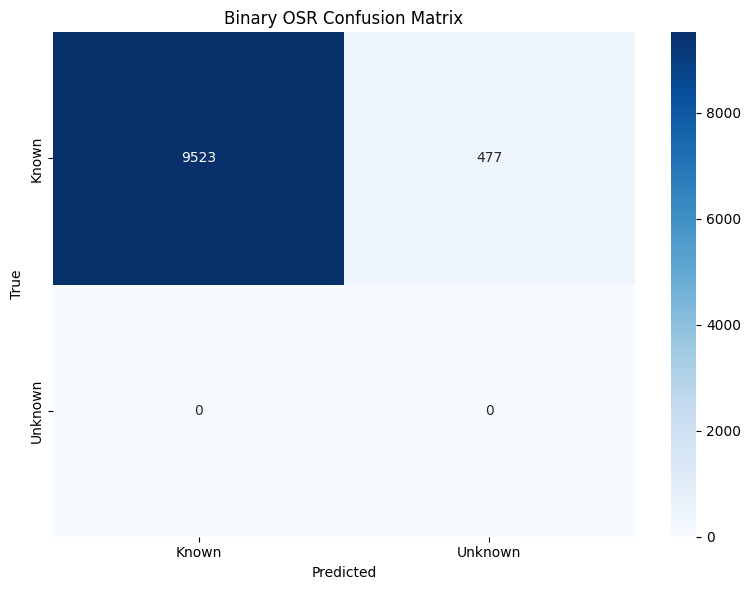

Known Accuracy: 95.23%
Unknown Accuracy: 0.00%
Total Binary Accuracy: 95.23%

 OSR evaluation (11-class classification):


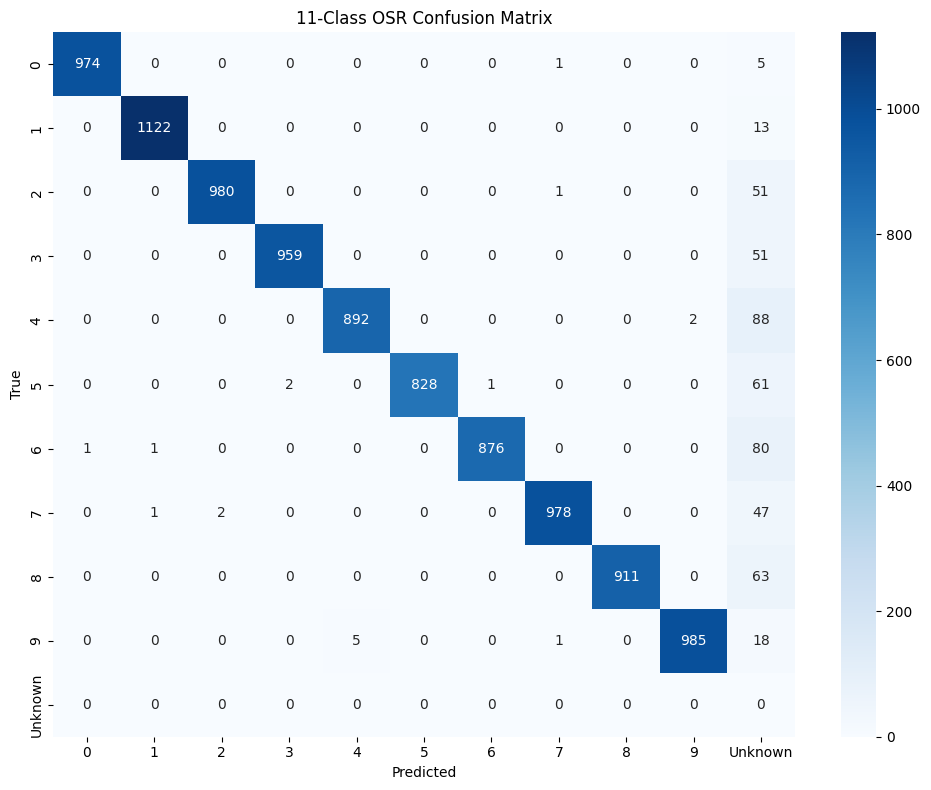

OSR Multiclass Accuracy: 95.05%


ZeroDivisionError: division by zero

In [ ]:
#######################################
# Evaluation - Unknown Dataset
#######################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.datasets import MNIST, CIFAR10 ## replace CIFAR10 with desired dataset

mnist_test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))

# Create an empty dataset for unknown samples
####################### replace CIFAR10 with desired dataset #############################
osr_dataset = Subset(CIFAR10('./data', train=False, download=True, transform=transforms.Compose([])), [])

# Create a combined dataset with MNIST test set and the empty unknown dataset
combined_osr_dataset = CombinedDataset(mnist_test, osr_dataset)
combined_osr_loader = DataLoader(combined_osr_dataset, batch_size=256)

# Load model weights
baseline_path = './baseline_model.pth'
osr_path = './osr_model.pth'

# Load baseline model
baseline_model = DHRNet(num_classes=10, bottleneck_dim=32).to(device)
baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))

# Load OSR model
checkpoint = torch.load(osr_path, map_location=device)
osr_model = CROSRModel(num_classes=10, bottleneck_dim=32).to(device)
osr_model.dhr_net.load_state_dict(checkpoint['model_state_dict'])
osr_model.class_means = checkpoint['class_means']
osr_model.threshold = checkpoint['threshold']
osr_model.weibull_params = checkpoint.get('weibull_params')
osr_model.fitted = checkpoint['fitted']

# OOD results: binary classification (Known vs Unknown)
print("\n OOD evaluation (binary classification):")
mnist_test_loader = DataLoader(mnist_test, batch_size=256)
empty_loader = DataLoader(osr_dataset, batch_size=256)

known_acc, unknown_acc, binary_acc = evaluate_osr_binary(
    osr_model,
    mnist_test_loader,
    empty_loader,
    device
)
print(f"Known Accuracy: {known_acc*100:.2f}%")
print(f"Unknown Accuracy: {unknown_acc*100:.2f}%")
print(f"Total Binary Accuracy: {binary_acc*100:.2f}%")

# OSR results: 11-class classification
print("\n OSR evaluation (11-class classification):")
# Using the placeholder combined OSR dataset
osr_acc, osr_preds, osr_targets = evaluate_osr_multiclass(
    osr_model,
    combined_osr_loader,
    device
)
print(f"OSR Multiclass Accuracy: {osr_acc*100:.2f}%")

acc_mnist, acc_ood, acc_total = eval_model(
    osr_model,
    combined_osr_loader,
    device
)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}% (no samples)')
print(f'Total Accuracy: {acc_total*100:.2f}%')
